<a href="https://colab.research.google.com/github/OJB-Quantum/Ideas-for-DUV-LASER-Diode-Litho/blob/main/DUV_Diode_LASER_Litho_to_Market_Estimated_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: ace_tools.display_dataframe_to_user not available; printing head instead.
      date                                                                                                event wavelength_nm             mode                                                                                key_specs                                                                          notes                                                                sources
2019-11-05         Deep‑UV semiconductor LD lasing at 271.8 nm under *pulsed* current at room temperature (RT).         271.8       Pulsed, RT                          Pulsed lasing; first in UV‑C band for electrically injected LD.                                 Asahi Kasei & Nagoya University demonstration.                                         Asahi Kasei press (2019-11-05)
2022-11-24                                 World’s first *continuous‑wave* (CW) deep‑UV LD at RT around 274 nm.           274           CW, RT Threshold cur

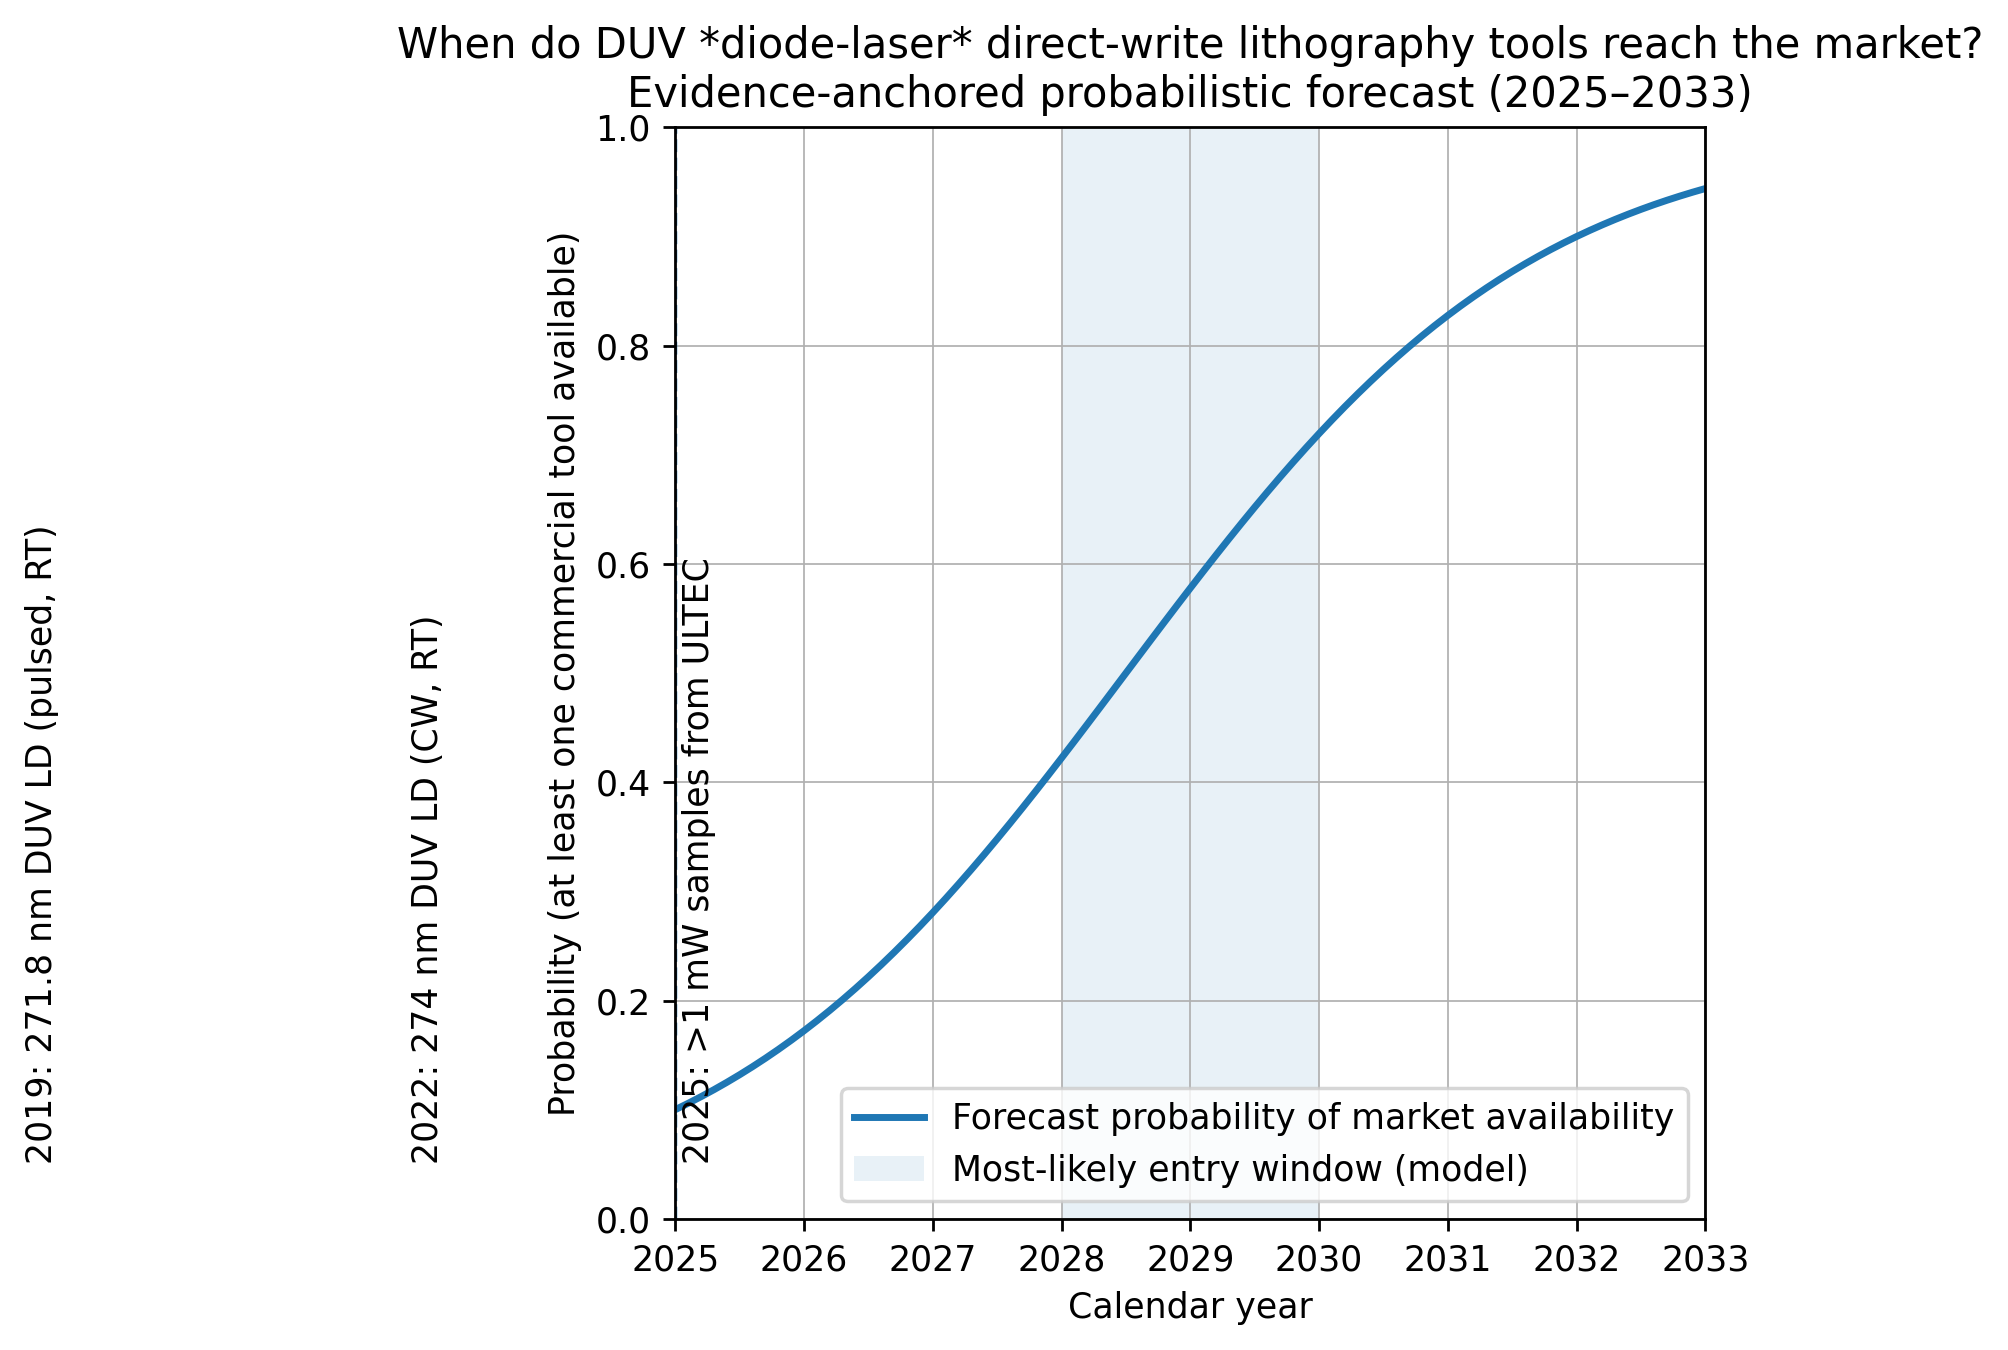

Model parameters: k = 0.628, x0 = 2028.50, P(2026) ≈ 0.172


In [4]:
# %%
"""
Forecast plot and evidence tables for DUV diode‑laser direct‑write lithography market entry.

This notebook cell constructs:
1) A milestone table (with literature anchors).
2) A simple logistic forecast for the probability that at least one commercial
   *diode‑laser*-based DUV direct‑write lithography tool is available in the market by year.
3) A publication‑ready matplotlib plot saved to /mnt/data/duv_diodelitho_forecast.png.

Notes:
- We intentionally avoid seaborn and styles; we follow pure matplotlib.
- No explicit colors are set, per instructions.
"""
from __future__ import annotations

from dataclasses import dataclass
from typing import List, Tuple

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 250

# ---- 1) Milestones (curated from literature) ----
@dataclass
class Milestone:
    date: str
    event: str
    wavelength_nm: str
    mode: str
    key_specs: str
    notes: str
    sources: str


milestones: List[Milestone] = [
    Milestone(
        date="2019-11-05",
        event="Deep‑UV semiconductor LD lasing at 271.8 nm under *pulsed* current at room temperature (RT).",
        wavelength_nm="271.8",
        mode="Pulsed, RT",
        key_specs="Pulsed lasing; first in UV‑C band for electrically injected LD.",
        notes="Asahi Kasei & Nagoya University demonstration.",
        sources="Asahi Kasei press (2019-11-05)"
    ),
    Milestone(
        date="2022-11-24",
        event="World’s first *continuous‑wave* (CW) deep‑UV LD at RT around 274 nm.",
        wavelength_nm="274",
        mode="CW, RT",
        key_specs="Threshold current density ≈ 4.2 kA/cm²; threshold voltage ≈ 8.7 V; T0 ≈ 70 K (reported).",
        notes="Defect suppression and distributed polarization doping (DPD) on AlN substrate.",
        sources="Applied Physics Letters (reported via Semiconductor Today, 2023-01-05)"
    ),
    Milestone(
        date="2024-02-14",
        event="Optically pumped AlGaN DUV laser at 278 nm with nanoporous cladding enabling low threshold.",
        wavelength_nm="278",
        mode="Optically pumped",
        key_specs="Room‑temperature lasing; threshold ≈ 79 kW/cm²; TE‑dominant emission.",
        notes="Architectural advance that is compatible with electrically driven designs.",
        sources="Optics Letters (2024-02-14)"
    ),
    Milestone(
        date="2025-04-01",
        event="Startup ULTEC founded to commercialize DUV LDs; engineering samples announced.",
        wavelength_nm="~275",
        mode="CW, RT (samples)",
        key_specs="> 1 mW optical output, TO‑5.6 CAN package; engineering samples offered.",
        notes="Spin‑out from Asahi Kasei ecosystem; Nagoya University collaboration.",
        sources="ULTEC website (2025)"
    ),
    Milestone(
        date="2017–2025",
        event="Benchmark for maskless lithography today: DPSS/frequency‑converted DUV lasers at 266 nm widely used.",
        wavelength_nm="266",
        mode="CW",
        key_specs="Typical 150–300 mW CW, single‑frequency; industrial reliability (≥10,000 h typical).",
        notes="Sets power/beam‑quality/lifetime bar for diode LDs to match.",
        sources="TOPTICA TopWave 266, OXIDE Frequad, Coherent Azure NX datasheets"
    ),
]

milestone_df = pd.DataFrame([m.__dict__ for m in milestones])

# Display the milestone table in an interactive grid
try:
    from ace_tools import display_dataframe_to_user  # type: ignore
    display_dataframe_to_user("DUV diode‑laser milestones (evidence table)", milestone_df)
except Exception as exc:  # pragma: no cover
    print("Note: ace_tools.display_dataframe_to_user not available; printing head instead.")
    print(milestone_df.to_string(index=False))

# ---- 2) Forecast model (logistic CDF anchored to literature‑driven dates) ----
# We model the probability that at least one commercial DUV *diode‑laser* direct‑write lithography tool
# (i.e., a tool whose primary exposure source is an electrically injected DUV LD) is available in the market in a given year.
# Anchor points (soft constraints):
#   P(2026) ≈ 0.2   # early pilot based on 2025 samples / 2026 target announcements
#   P(2028.5) ≈ 0.5 # median "most likely" arrival
#   P(2032) ≈ 0.9   # high confidence by early 2030s, assuming continued device maturation
anchors: List[Tuple[float, float]] = [(2026.0, 0.20), (2028.5, 0.50), (2032.0, 0.90)]

def fit_logistic_from_two_points(x_mid: float, p_mid: float, x_hi: float, p_hi: float) -> Tuple[float, float]:
    """
    Fit a simple logistic P(x) = 1 / (1 + exp(-k*(x - x0))) through two anchor points.
    Returns (k, x0). This under-determines a third anchor; we choose (x_mid, p_mid), (x_hi, p_hi).
    """
    # logit(p) = ln(p/(1-p)) = k*(x - x0)
    def logit(p: float) -> float:
        eps = 1e-12
        p = min(max(p, eps), 1 - eps)
        return math.log(p / (1.0 - p))

    L_mid = logit(p_mid)
    L_hi = logit(p_hi)
    k = (L_hi - L_mid) / (x_hi - x_mid)
    x0 = x_mid - L_mid / k
    return k, x0

k, x0 = fit_logistic_from_two_points(anchors[1][0], anchors[1][1], anchors[2][0], anchors[2][1])

# Compute probabilities for a dense year grid
years = np.linspace(2025, 2033, 81)
probs = 1.0 / (1.0 + np.exp(-k * (years - x0)))

# Evaluate the third (low‑year) anchor for diagnostic
def logit(p: float) -> float:
    eps = 1e-12
    p = min(max(p, eps), 1 - eps)
    return math.log(p / (1.0 - p))

p_2026_model = 1.0 / (1.0 + math.exp(-k * (2026.0 - x0)))

# ---- 3) Plot ----
plt.figure(figsize=(9, 5.5))
plt.plot(years, probs, linewidth=2, label="Forecast probability of market availability")
# Add vertical lines for key milestones
milestone_years = [2019.9, 2022.9, 2025.0]  # approximate decimal years for positioning
milestone_labels = [
    "2019: 271.8 nm DUV LD (pulsed, RT)",
    "2022: 274 nm DUV LD (CW, RT)",
    "2025: >1 mW samples from ULTEC"
]
for x_v, lab in zip(milestone_years, milestone_labels):
    plt.axvline(x=x_v, linestyle="--", linewidth=1)
    plt.text(x_v + 0.05, 0.05, lab, rotation=90, va="bottom", ha="left")

# Annotate likely window shading
ymin, ymax = plt.ylim()
plt.fill_between([2028.0, 2030.0], 0, 1, alpha=0.1, label="Most‑likely entry window (model)")

plt.title("When do DUV *diode‑laser* direct‑write lithography tools reach the market?\nEvidence‑anchored probabilistic forecast (2025–2033)")
plt.xlabel("Calendar year")
plt.ylabel("Probability (at least one commercial tool available)")
plt.xlim(2025, 2033)
plt.ylim(0, 1)
plt.grid(True, which="both", axis="both", linewidth=0.5)
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

print(f"Model parameters: k = {k:.3f}, x0 = {x0:.2f}, P(2026) ≈ {p_2026_model:.3f}")


Key References:

| Date | Milestone | Mode | λ (nm) | Some Specs | Source |
|---|---|---|---|---|---|
| 2019‑11‑05 | World’s shortest DUV LD lasing at 271.8 nm under pulsed current at RT | Pulsed | 271.8 | First in UV‑C band for electrically injected LD | (Asahi Kasei) |
| 2022‑11‑24 | First CW deep‑UV LD at RT (~274 nm) | CW | 274 | J_th ≈ 4.2 kA/cm², V_th ≈ 8.7 V, T₀ ≈ 70 K | (Asahi Kasei, Semiconductor Today) |
| 2024‑02‑14 | 278 nm optically pumped AlGaN laser with nanoporous cladding, low threshold | Optically pumped | 278 | ~79 kW/cm² threshold, TE‑dominant | (Optica Publishing Group) |
| 2025‑04–07 | ULTEC spin‑out; engineering samples >1 mW @ ~275 nm (TO‑5.6) | CW (samples) | ~275 | “Offering engineering samples” | (ULTEC) |
| 2017–2025 | Commercial DUV DPSS/fiber lasers used in lithography | CW | 229–266 | 150–300 mW CW, single‑frequency, ≥10,000 h | (TOPTICA Photonics SE, Coherent Inc) |